## Problem Statement ##

This python code aims to build a classifier for the accident risk of various locations in NYC on a particular day and time. The classifier <br>
tries to classify locations into risk categories : HIGH, LOW and MEDIUM based on the various weather features that have been imported into the <br>
data set previously using openmeteo. The utility of this model lies in the fact that authorities can plan their constrained resources much more <br>efficiently if they know which location at a given time and day is more likely to see accident spike. This can potentially lead to quicker response <br>time and increased safety.

### Data Preparation ###

This next section deals mostly with data cleaning. The final_data.csv file contains the original data downloaded from the NYC <br>
motor vehicle crash website joined with the weather data that was imported using the weather_data_import.ipynb code. Various features are<br>
formatted, and ultimately only the one's used in training are kept. The task of feature selection was done iteratively, various models were<br>
trained to see which features are relevant.

In [1]:
# Import necessary packages.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier

In [ ]:
# Read the main data set that contains the accident information and the weather information
df = pd.read_csv('C:/Users/mehra/OneDrive/Desktop/APP/FDS_Project/final_data/content/final_data.csv')

In [88]:
# Print all the columns that are originally in the joined data set
column_names = df.columns
print(column_names)

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'STRTNAME_BOROUGH', 'DATE', 'TEMPERATURE_2M', 'RELATIVE_HUMIDITY_2M',
       'PRECIPITATION', 'RAIN', 'SNOWFALL', 'SNOW_DEPTH', 'WEATHER_CODE',
       'CLOUD_COVER', 'WIND_SPEED_100M', 'WIND_DIRECTION_100M', 'IS_DAY'],
      dtype='obje

In [89]:
# DATA PROCESSING: Split the real lat long, delete the location column
# The lat long in this data set have been replaced by representative lat long previously
# Howver, the LOCATION column still contains the real lat long - so split it into two columns
# Create new columns for latitude and longitude
df[['REAL_LATITUDE', 'REAL_LONGITUDE']] = df['LOCATION'].str.strip('()').str.split(',', expand=True)

# Convert the new columns to numeric (float) types
df['REAL_LATITUDE'] = pd.to_numeric(df['REAL_LATITUDE'], errors='coerce')
df['REAL_LONGITUDE'] = pd.to_numeric(df['REAL_LONGITUDE'], errors='coerce')

# Drop the original df['LOCATION'] column
df.drop('LOCATION', axis=1, inplace=True)

# Display the modified DataFrame
print(df.head(8))


   CRASH DATE CRASH TIME   BOROUGH ZIP CODE  LATITUDE  LONGITUDE  \
0  2021-09-11   10:00:00  BROOKLYN  11208.0   40.6975 -73.886633   
1  2021-09-11   10:00:00  BROOKLYN  11212.0   40.6975 -73.886633   
2  2021-12-14   08:00:00  BROOKLYN  11233.0   40.6975 -73.886633   
3  2021-12-14   08:00:00       NaN      NaN   40.6975 -73.886633   
4  2021-12-14   08:00:00       NaN      NaN   40.6975 -73.886633   
5  2021-12-14   08:00:00  BROOKLYN  11207.0   40.6975 -73.886633   
6  2021-12-14   17:00:00       NaN      NaN   40.6975 -73.979750   
7  2021-12-14   17:00:00  BROOKLYN  11211.0   40.6975 -73.979750   

                              ON STREET NAME  CROSS STREET NAME  \
0                                        NaN                NaN   
1                                        NaN                NaN   
2             SARATOGA AVENUE NYC,  New York     DECATUR STREET   
3             ATLANTIC AVENUE NYC,  New York                NaN   
4               EUCLID AVENUE NYC,  New York        

In [90]:
# DATA PROCESSING: Delete unnecessary columns
# These columns either present redundant information, or have mostly null 
# values or are not important for training purposes.
# We did not use the contributing factor and vehicle type in our training
# as those are post-accident features and we are trying to predict the 
# accident likelihood.
df.drop('CROSS STREET NAME', axis=1, inplace=True)
df.drop('OFF STREET NAME', axis=1, inplace=True)
df.drop('ON STREET NAME', axis=1, inplace=True)
df.drop('CONTRIBUTING FACTOR VEHICLE 1', axis=1, inplace=True)
df.drop('CONTRIBUTING FACTOR VEHICLE 2', axis=1, inplace=True)
df.drop('CONTRIBUTING FACTOR VEHICLE 3', axis=1, inplace=True)
df.drop('CONTRIBUTING FACTOR VEHICLE 4', axis=1, inplace=True)
df.drop('CONTRIBUTING FACTOR VEHICLE 5', axis=1, inplace=True)
df.drop('COLLISION_ID', axis=1, inplace=True)
df.drop('DATE', axis=1, inplace=True)
df.drop('VEHICLE TYPE CODE 1', axis=1, inplace=True)
df.drop('VEHICLE TYPE CODE 2', axis=1, inplace=True)
df.drop('VEHICLE TYPE CODE 3', axis=1, inplace=True)
df.drop('VEHICLE TYPE CODE 4', axis=1, inplace=True)
df.drop('VEHICLE TYPE CODE 5', axis=1, inplace=True)


In [91]:
# DATA PROCESSING:  Drop columns which dont have a zip code
df = df.dropna(subset=['ZIP CODE'])
# Display the modified DataFrame shape
print(df.shape)

(1455569, 30)


In [93]:
# DATA PROCESSING:  Extract day, month and year from the crash date column
# This is important for one hot encoding later on
# Convert 'CRASH DATE' to datetime format
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

# Extract day, month, and year
df['DAY'] = df['CRASH DATE'].dt.day
df['MONTH'] = df['CRASH DATE'].dt.month
df['YEAR'] = df['CRASH DATE'].dt.year

# Drop the original 'CRASH DATE' column
df = df.drop(columns=['CRASH DATE'])

df['DAY'] = df['DAY'].astype(str)
df['MONTH'] = df['MONTH'].astype(str)
df['YEAR'] = df['YEAR'].astype(str)


# Display the modified DataFrame
print(df[['DAY', 'MONTH', 'YEAR']].head())


  DAY MONTH  YEAR
0  11     9  2021
1  11     9  2021
2  14    12  2021
5  14    12  2021
7  14    12  2021


In [ ]:
# DATA PROCESSING:  Extract the hour from crash time
# This is important for one hot encoding later on
# Convert 'CRASH TIME' to datetime format
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'])

# Extract the hour
df['HOUR'] = df['CRASH TIME'].dt.hour

# Drop the original 'CRASH TIME' column
df = df.drop(columns=['CRASH TIME'])
df['HOUR'] = df['HOUR'].astype(str)



In [95]:
# EDA: See the number of distinct WMO weather codes in the data set
# The number is small so this column can be one-hot encoded too.
df['WEATHER_CODE'] = df['WEATHER_CODE'].astype(str)
unique_weather_values = df['WEATHER_CODE'].unique()
# Print the unique values in the 'WEATHER' column
print("Unique values in the 'WEATHER' column:")
print(unique_weather_values)

Unique values in the 'WEATHER' column:
['0.0' '1.0' '3.0' '2.0' '51.0' '53.0' '71.0' '63.0' '55.0' '61.0' '73.0'
 '65.0' '75.0']


In [ ]:
# Data Enhancing: Add 1 across all the persons injured columns
# This is because there are a lot of row with persons injured + killed = 0
# As we are trying to define risk percentage, using this as it is will results
# in bias towards 0 percentage - which is not right as the accident did happen
# even though no injury was reported. Our final metric is to classify the accident
# likeliness and it is a percentage. So boosting this column does not logically 
# change the definition of risk
df['NUMBER OF PERSONS INJURED'] = df['NUMBER OF PERSONS INJURED'] + 1

In [ ]:
# TARGET DEFINITION: We define the TOTAL_RISK of a place as the sum of number of persons killed and injured
df['TOTAL_RISK'] = df['NUMBER OF PERSONS INJURED'] + df['NUMBER OF PERSONS KILLED']

#TARGET DEFINITION: We define MAX_TOTAL_RISK_PER_ZIP as the max TOTAL_RISK for a particular zip code
df['MAX_TOTAL_RISK_PER_ZIP'] = df.groupby([ 'ZIP CODE'])['TOTAL_RISK'].transform('max')

# TARGET DEFINITION: We define TOTAL_RISK_PC as the percentage risk of a place on a given day and time
# This is the TOTAL_RISK of the place on the day and ntime / max risk of that zip code 
# We will use this distribution to uniformly divide the accidents into three classes - LOW, MEDIUM and HIGH
df['TOTAL_RISK_PC'] = (df['TOTAL_RISK'] / df['MAX_TOTAL_RISK_PER_ZIP'] )*100

# Drop the intermediate columns
df.drop('TOTAL_RISK', axis=1, inplace=True)
df.drop('MAX_TOTAL_RISK_PER_ZIP', axis=1, inplace=True)

In [99]:
# DATA PROCESSING: As we have defined our TOTAL_RISK_PC target variable, these
# columns are no longer needed
df.drop('NUMBER OF PERSONS INJURED',  axis=1, inplace=True)
df.drop('NUMBER OF PERSONS KILLED', axis=1, inplace=True)
# The following columns are redundant. Their information has 
# already been summed up in the NUMBER OF PERSONS INJURED and 
# NUMBER OF PERSONS KILLED fields.
df.drop('NUMBER OF PEDESTRIANS INJURED', axis=1, inplace=True)
df.drop('NUMBER OF PEDESTRIANS KILLED', axis=1, inplace=True)
df.drop('NUMBER OF CYCLIST INJURED', axis=1, inplace=True)
df.drop('NUMBER OF CYCLIST KILLED', axis=1, inplace=True)
df.drop('NUMBER OF MOTORIST INJURED',  axis=1, inplace=True)
df.drop('NUMBER OF MOTORIST KILLED', axis=1, inplace=True)
df.drop('REAL_LATITUDE', axis=1, inplace=True)
df.drop('REAL_LONGITUDE', axis=1, inplace=True)
df.drop('STRTNAME_BOROUGH', axis=1, inplace=True)
df.drop('LATITUDE', axis=1, inplace=True)
df.drop('LONGITUDE', axis=1, inplace=True)

In [100]:
# DATA PROCESSING: Setting correct data type for one-hot encoding later
df['ZIP CODE'] = df['ZIP CODE'].astype(str)

In [101]:
# EDA: Print the set of final features and targets
column_names = df.columns
print(column_names)
# Drop all nulls as the final features have been assumed to be complete
df = df.dropna()

Index(['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'ON STREET NAME',
       'TEMPERATURE_2M', 'RELATIVE_HUMIDITY_2M', 'PRECIPITATION', 'RAIN',
       'SNOWFALL', 'SNOW_DEPTH', 'WEATHER_CODE', 'CLOUD_COVER',
       'WIND_SPEED_100M', 'WIND_DIRECTION_100M', 'IS_DAY', 'DAY', 'MONTH',
       'YEAR', 'HOUR', 'TOTAL_RISK_PC'],
      dtype='object')


In [102]:
# This is the final shape of the training + test data
print(df.shape)

(1116601, 21)


In [76]:
# DATA PROCESSING: In order to create the final class column (RISK_CATEGORY),
# We need to divide the TOTAL_RISK_PC distribution uniformly into 3 bins, 
# for LOW, MEDIUM and HIGH. This block tries to find the correct cut-off
# boundaries that can result in a near uniform distribution
# Specify the number of bins
n_bins = 3

# Divide the column into bins with equal sample sizes
df['bin'] = pd.qcut(df['TOTAL_RISK_PC'], q=n_bins, labels=False)

# Calculate ranges and counts
bin_counts = df['bin'].value_counts().sort_index()
bin_ranges = pd.qcut(df['TOTAL_RISK_PC'], q=n_bins).cat.categories

# Print ranges and counts
for i, (bin_range, count) in enumerate(zip(bin_ranges, bin_counts)):
    print(f"Bin {i + 1}: {bin_range}, Count: {count}")


Bin 1: (2.2720000000000002, 9.091], Count: 378540
Bin 2: (9.091, 14.286], Count: 425771
Bin 3: (14.286, 100.0], Count: 312290


In [103]:
# TARGET DEFINITION: Create the final CLASS column - RISK CATEGORY. Based on the bins determined above.
df['RISK_CATEGORY'] = np.select(
    [
        (df['TOTAL_RISK_PC'] <= 9.091),
        (df['TOTAL_RISK_PC'] > 9.091) & (df['TOTAL_RISK_PC'] <= 14.286),
        (df['TOTAL_RISK_PC'] > 14.286)
    ],
    ['LOW', 'MEDIUM', 'HIGH'],
    default='UNKNOWN' 
)
df.head()

,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,TEMPERATURE_2M,RELATIVE_HUMIDITY_2M,PRECIPITATION,RAIN,SNOWFALL,...,CLOUD_COVER,WIND_SPEED_100M,WIND_DIRECTION_100M,IS_DAY,DAY,MONTH,YEAR,HOUR,TOTAL_RISK_PC,RISK_CATEGORY
2,BROOKLYN,11233.0,40.697500000000005,-73.88663333333334,"SARATOGA AVENUE NYC, New York",3.663,59.556360,0.0,0.0,0.0,...,6.9,28.236486,289.35907,0.0,14,12,2021,8,7.692308,LOW
5,BROOKLYN,11207.0,40.697500000000005,-73.88663333333334,"ARLINGTON AVENUE NYC, New York",3.663,59.556360,0.0,0.0,0.0,...,6.9,28.236486,289.35907,0.0,14,12,2021,8,6.666667,LOW
7,BROOKLYN,11211.0,40.697500000000005,-73.97975,"GRAND STREET NYC, New York",10.211,47.245678,0.0,0.0,0.0,...,20.1,16.454008,349.91946,1.0,14,12,2021,17,18.181818,HIGH
8,BROOKLYN,11238.0,40.697500000000005,-73.97975,"LAFAYETTE AVENUE NYC, New York",10.211,47.245678,0.0,0.0,0.0,...,20.1,16.454008,349.91946,1.0,14,12,2021,17,9.090909,LOW
9,MANHATTAN,10002.0,40.697500000000005,-73.97975,"EAST HOUSTON STREET NYC, New York",10.211,47.245678,0.0,0.0,0.0,...,20.1,16.454008,349.91946,1.0,14,12,2021,17,12.500000,MEDIUM


In [ ]:
# DATA PROCESSING: Delete intermediate columns. The data is ready for training now
df.drop('TOTAL_RISK_PC', axis=1, inplace=True)
df.drop('bin', axis=1, inplace=True)

### Training the model ###

The data set is now ready. We begin training the classification model. RandomForest seemed like a natural choice because 1) It handles mix of <br>categorical and numerical data very well. 2) It performs well with one-hot encoding. 3) It is not sensitive to the scale of the data which is<br> a concern with so many weather features. 4) It is not naturally prone to overfitting.

In [105]:
# One hot encoding the categorical columns
df = pd.get_dummies(df, columns=['BOROUGH', 'WEATHER_CODE', 'ZIP CODE','DAY', 'MONTH', 'YEAR', 'HOUR','IS_DAY'])

In [107]:
# Run the RandomForest classifier with default parameters and 80:20 split.
# Extract target variable
target = 'RISK_CATEGORY'
y = df[target]

# Extract features
X = df.drop(columns=[target])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.7924601806368411
Confusion Matrix:
[[28551 12970 20688]
 [ 1995 72934   908]
 [ 2934  6853 75488]]
Classification Report:
              precision    recall  f1-score   support

        HIGH       0.85      0.46      0.60     62209
         LOW       0.79      0.96      0.87     75837
      MEDIUM       0.78      0.89      0.83     85275

    accuracy                           0.79    223321
   macro avg       0.81      0.77      0.76    223321
weighted avg       0.80      0.79      0.78    223321



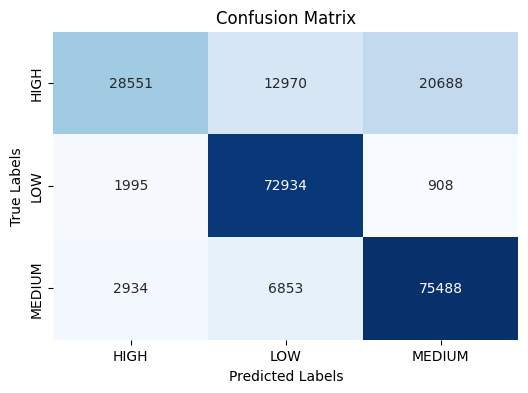

In [108]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


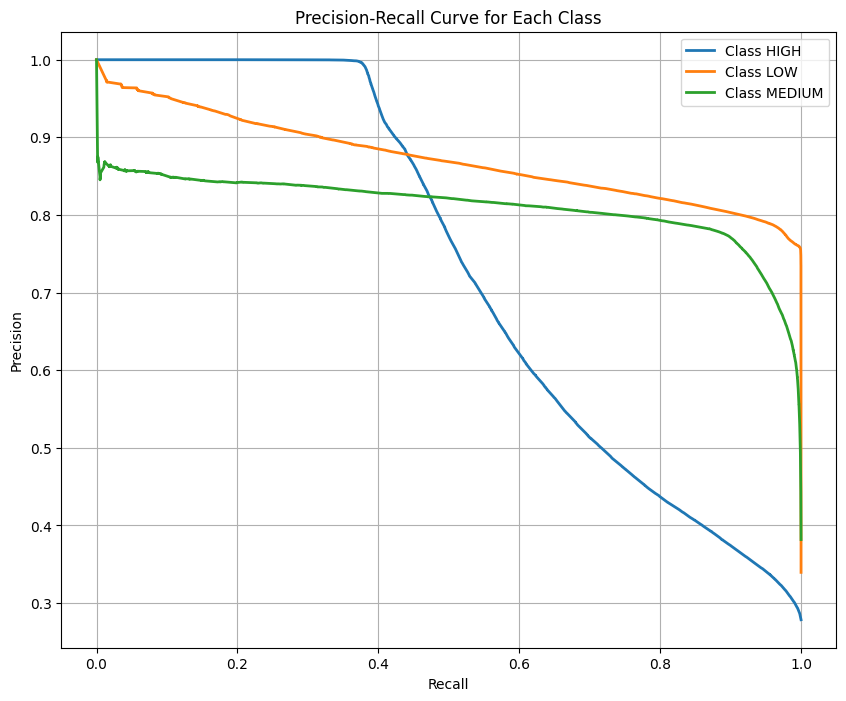

In [109]:
# Get precision and recall values for each class
precision = dict()
recall = dict()
for i, class_label in enumerate(rf_classifier.classes_):
    precision[class_label], recall[class_label], _ = precision_recall_curve((y_test == class_label).astype(int), rf_classifier.predict_proba(X_test)[:, i])

# Plot precision-recall curves for each class
plt.figure(figsize=(10, 8))
for class_label in rf_classifier.classes_:
    plt.plot(recall[class_label], precision[class_label], lw=2, label=f'Class {class_label}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.grid()
plt.show()


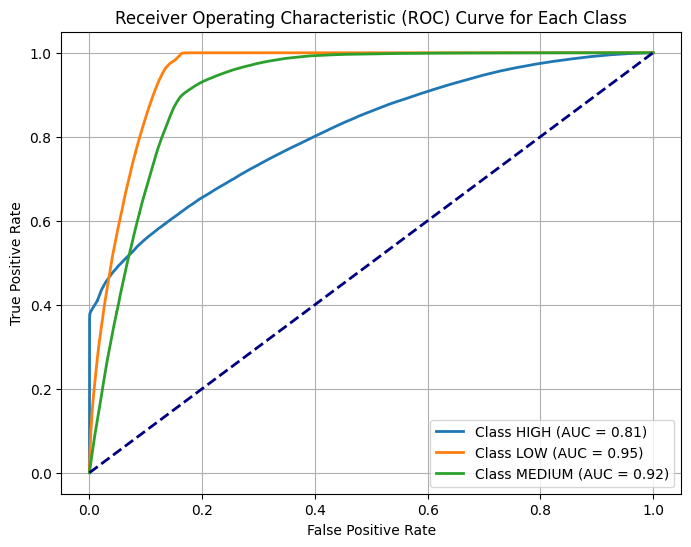

In [110]:
# Get ROC curve values for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(rf_classifier.classes_):
    fpr[class_label], tpr[class_label], _ = roc_curve((y_test == class_label).astype(int), rf_classifier.predict_proba(X_test)[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for class_label in rf_classifier.classes_:
    plt.plot(fpr[class_label], tpr[class_label], lw=2, label=f'Class {class_label} (AUC = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.grid()
plt.legend()
plt.show()


### Random Forest with Hyper-parameter tuning ###

In the next section, we ran the random forest with hyper paramater tuning. We used RandomizedSearchCV for this, and ran it for a set <br>
of 30 different hyperparameters (n_estimators, max_depth, min_samples_split, min_samples_leaf). This code takes a long time to run ( > 10 hours)

In [28]:
# Extract target variable
target = 'RISK_CATEGORY'
y = df[target]

# Extract features
X = df.drop(columns=[target])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Print best parameters and results
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Make predictions on the test set using the best model
y_pred = random_search.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Best Score: 0.7966886082751209
Accuracy: 0.7998755155135433
Confusion Matrix:
[[25108 18611 18293]
 [  326 88536    54]
 [  381  7027 64985]]
Classification Report:
              precision    recall  f1-score   support

        HIGH       0.97      0.40      0.57     62012
         LOW       0.78      1.00      0.87     88916
      MEDIUM       0.78      0.90      0.83     72393

    accuracy                           0.80    223321
   macro avg       0.84      0.77      0.76    223321
weighted avg       0.83      0.80      0.78    223321



### XGBoost Model ###

We also ran the model with XGBoost. While XGBoost runs significantly faster than RandomForest, it gave slightly worse results.

In [82]:
# Using XGBoost

class_mapping = {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2}
df['RISK_CATEGORY'] = df['RISK_CATEGORY'].map(class_mapping)
# Extract target variable
target = 'RISK_CATEGORY'
y = df[target]

# Extract features
X = df.drop(columns=[target])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=42)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


C:\Users\mehra\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mehra\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\mehra\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\mehra\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

Accuracy: 0.7861777441440796
Confusion Matrix:
[[73725   835  1277]
 [ 8041 77234     0]
 [14560 23038 24611]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86     75837
           1       0.76      0.91      0.83     85275
           2       0.95      0.40      0.56     62209

    accuracy                           0.79    223321
   macro avg       0.83      0.76      0.75    223321
weighted avg       0.82      0.79      0.76    223321

